In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [2]:
# Load the dataset
bbc_news = pd.read_csv('D:\Anu\Kaggle\BBCnews.csv')

In [3]:
# Summary of the dataset
print(bbc_news.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2236 entries, 0 to 2235
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    2233 non-null   object
 1   labels  2236 non-null   object
dtypes: object(2)
memory usage: 35.1+ KB
None


In [4]:
bbc_news.head()

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


## Data Cleaning and Preprocessing

In [5]:
# Fill missing values in the 'data' column with empty strings
bbc_news['data'] = bbc_news['data'].fillna('')

# Convert all entries in the 'data' column to strings
bbc_news['data'] = bbc_news['data'].astype(str)

# Clean the dataset
bbc_news = bbc_news.drop_duplicates()
bbc_news['data'] = bbc_news['data'].str.lower().str.replace('[^\w\s]', '',regex=True)

# Display basic information
print(bbc_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2128 entries, 0 to 2230
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    2128 non-null   object
 1   labels  2128 non-null   object
dtypes: object(2)
memory usage: 49.9+ KB
None


## Function to preprocess text

In [6]:
from collections import Counter
from wordcloud import STOPWORDS

In [7]:
# tokenize the text data
def preprocess_text(text):
    tokens = text.lower().split()
    tokens = [token for token in tokens if token.isalpha() and token not in STOPWORDS]
    return tokens
pd.options.mode.chained_assignment = None

In [8]:
# Preprocess and explore data
bbc_news.loc[:,'tokens'] = bbc_news['data'].apply(preprocess_text)

## Exploratory Data Analysis (EDA)

In [9]:
# word frequencies
category_word_freq = {}
for category in bbc_news['labels'].unique():
    category_data = bbc_news[bbc_news['labels'] == category]['tokens']
    all_tokens = [token for sublist in category_data for token in sublist]
    category_word_freq[category] = Counter(all_tokens).most_common(10)

print(category_word_freq)

{'entertainment': [('said', 803), ('film', 692), ('best', 563), ('will', 554), ('music', 418), ('us', 350), ('one', 342), ('years', 324), ('new', 315), ('show', 298)], 'tech': [('said', 1364), ('will', 1072), ('people', 808), ('technology', 450), ('mr', 450), ('new', 448), ('one', 435), ('mobile', 419), ('games', 399), ('users', 348)], 'business': [('said', 1655), ('us', 776), ('will', 770), ('year', 599), ('mr', 596), ('market', 412), ('new', 401), ('company', 364), ('growth', 362), ('last', 356)], 'sport': [('said', 929), ('will', 890), ('game', 468), ('first', 433), ('win', 410), ('england', 394), ('last', 371), ('world', 369), ('one', 353), ('two', 349)], 'politics': [('said', 2173), ('mr', 1614), ('will', 951), ('government', 628), ('labour', 595), ('people', 580), ('election', 536), ('blair', 475), ('party', 461), ('new', 419)]}


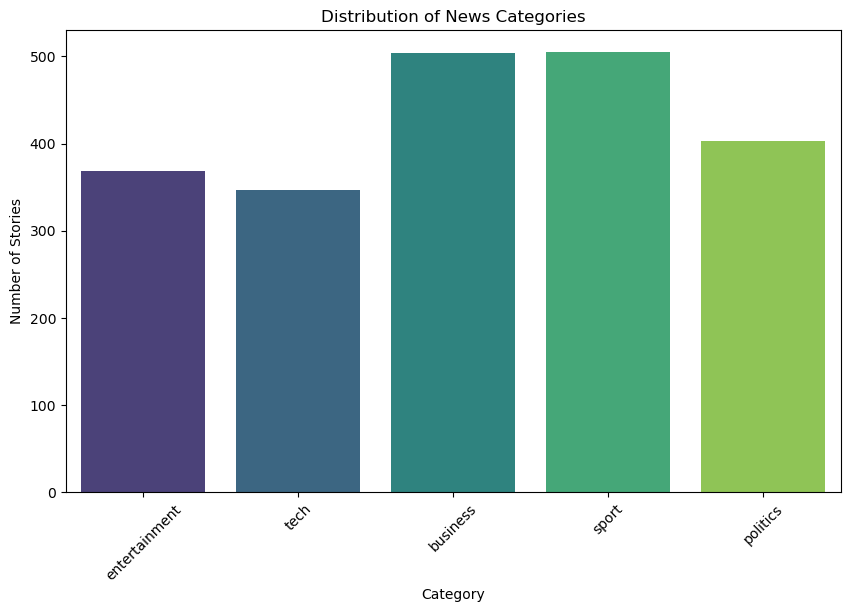

In [10]:
# Distribution of news categories
plt.figure(figsize=(10, 6))
sns.countplot(data=bbc_news, x='labels', palette='viridis')
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Number of Stories')
plt.xticks(rotation=45)
plt.show()

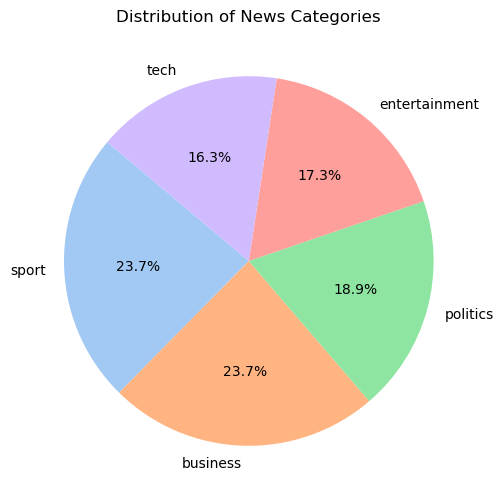

In [11]:
# Distribution of news categories using pie chart
category_counts = bbc_news['labels'].value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribution of News Categories')
plt.ylabel('')
plt.show()

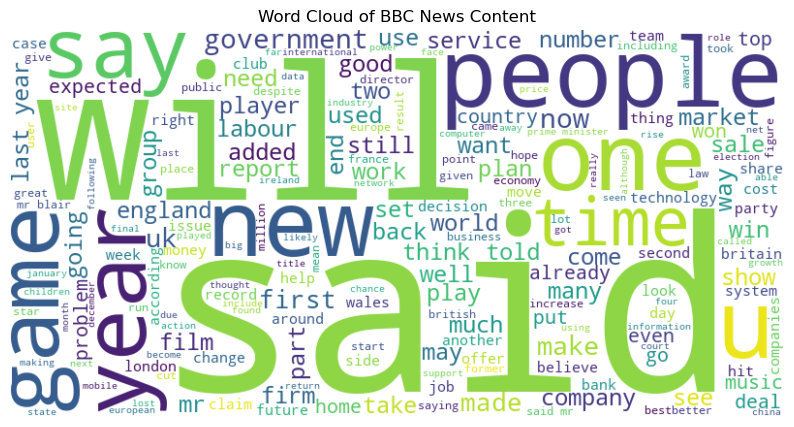

In [12]:
# Generate word cloud
text = ' '.join(bbc_news['data'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of BBC News Content')
plt.show()

In [13]:
# Topic Modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize the content
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(bbc_news['data'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Display topics
for index, topic in enumerate(lda.components_):
    print(f'Topic {index}:')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Topic 0:
['net', 'phone', 'users', 'mr', 'new', 'use', 'mobile', 'technology', 'people', 'said']
Topic 1:
['told', 'minister', 'party', 'blair', 'election', 'people', 'labour', 'government', 'mr', 'said']
Topic 2:
['sales', '2004', 'economy', 'growth', 'new', 'company', 'mr', 'market', 'year', 'said']
Topic 3:
['club', 'players', 'play', 'just', 'time', 'world', 'win', 'england', 'game', 'said']
Topic 4:
['tv', 'year', 'awards', 'games', 'new', 'years', 'best', 'music', 'said', 'film']


In [14]:
# Sentiment Analysis
from textblob import TextBlob

# Function to calculate sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Calculate sentiment scores
bbc_news['sentiment'] = bbc_news['data'].apply(get_sentiment)

# Display the first few rows with sentiment scores
print(bbc_news[['data', 'sentiment']].head())

                                                data  sentiment
0  musicians to tackle us red tape  musicians gro...   0.103425
1  u2s desire to be number one  u2 who have won t...   0.134256
2  rocker doherty in onstage fight  rock singer p...  -0.014458
3  snicket tops us box office chart  the film ada...  -0.011364
4  oceans twelve raids box office  oceans twelve ...   0.123258


## Text Classification Model

In [15]:
# Vectorize text data
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(bbc_news['data'])
y = bbc_news['labels']

In [16]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Train a Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     business       0.91      0.99      0.95       108
entertainment       1.00      0.91      0.95        74
     politics       0.91      0.94      0.93        80
        sport       0.99      1.00      0.99        92
         tech       0.97      0.89      0.93        72

     accuracy                           0.95       426
    macro avg       0.96      0.94      0.95       426
 weighted avg       0.95      0.95      0.95       426

